# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import geopandas as gpd
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [29]:
#import Data on Age Distribution in German counties from federal statistics department
dfA = pd.read_csv('dataX.csv', sep = ';')

#start cleaning by removing all rows whoch are empty
dfA.replace('-',None, inplace = True)
dfA.dropna(subset=['unter 3 Jahre'], inplace = True)
dfA.head()



,Datum,B-code,Landkreis,unter 3 Jahre,3 bis unter 6 Jahre,6 bis unter 10 Jahre,10 bis unter 15 Jahre,15 bis unter 18 Jahre,18 bis unter 20 Jahre,20 bis unter 25 Jahre,...,30 bis unter 35 Jahre,35 bis unter 40 Jahre,40 bis unter 45 Jahre,45 bis unter 50 Jahre,50 bis unter 55 Jahre,55 bis unter 60 Jahre,60 bis unter 65 Jahre,65 bis unter 75 Jahre,75 Jahre und mehr,Insgesamt
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",2709,2561,3127,3775,2284,1893,8521,...,6463,5135,4977,4855,6316,6342,5565,8861,9532,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",6683,6485,7895,9617,5761,4834,21478,...,20756,16442,14113,13308,16801,17553,14594,22414,24416,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",5371,5667,7127,8936,5508,3936,13454,...,14604,13005,12474,12300,16194,17318,14692,23374,27556,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",2135,2128,2853,3697,2298,1532,4842,...,5325,4690,4560,4571,6005,6275,5569,8583,9749,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",3241,3458,4432,5992,3758,2747,7122,...,7277,6906,7029,7536,10827,11875,10669,16993,17130,133969


In [30]:
# read the data into a DataFrame
dfA = dfA.apply(pd.to_numeric, errors = 'ignore')

#set age ranges
age_ranges = [
    ('20 bis unter 25 Jahre', '25 bis unter 30 Jahre'),
    ('30 bis unter 35 Jahre', '35 bis unter 40 Jahre'),
    ('40 bis unter 45 Jahre', '45 bis unter 50 Jahre'),
    ('50 bis unter 55 Jahre', '55 bis unter 60 Jahre')
]

#loop over the age ranges and add them together
for age_range in age_ranges:
    col1, col2 = age_range
    lower_bound = int(col1.split()[0])
    upper_bound = int(col2.split()[0])
    new_col_name = f'{lower_bound}-{upper_bound}'
    dfA[new_col_name] = dfA[col1] + dfA[col2]

# drop irrelevant age ranges
dfA.drop(['unter 3 Jahre', '3 bis unter 6 Jahre', '6 bis unter 10 Jahre', '10 bis unter 15 Jahre', '15 bis unter 18 Jahre', '18 bis unter 20 Jahre', '20 bis unter 25 Jahre', '25 bis unter 30 Jahre', '30 bis unter 35 Jahre', '35 bis unter 40 Jahre', '40 bis unter 45 Jahre', '45 bis unter 50 Jahre', '50 bis unter 55 Jahre', '55 bis unter 60 Jahre', '60 bis unter 65 Jahre'], axis=1, inplace=True)




In [31]:
#remame the columns 
dfA_final = dfA.rename(columns = {'65 bis unter 75 Jahre':'65 to under 75 years', 'Landkreis':'County', 'Datum':'Date','75 Jahre und mehr':'75 years and older', 'Insgesamt':'Total', '20-25':'20 to under 30 years', '30-35':'30 to under 40 years', '40-45':'40 to under 50 years', '50-55':'50 to under 60 years' })

# new column order 
new_column_order = ['Date', 'B-code', 'County', '20 to under 30 years', '30 to under 40 years', '40 to under 50 years', '50 to under 60 years', '65 to under 75 years', '75 years and older', 'Total']
dfA_final = dfA_final.reindex(columns=new_column_order)

# display the modified DataFrame
dfA_final.head()

,Date,B-code,County,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,Total
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,91113
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,246243
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,216277
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,79496
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,133969


In [19]:
#add column to construct a ratio between >65year olds in comparison to whole population
#test, will be used later -- possibly more ratios in AGE dataframe done here?
dfA_final["ratio_65year"] = (dfA_final["65 to under 75 years"] + dfA_final["75 years and older"]) / dfA_final["Total"]

print(dfA_final[["ratio_65year"]])

     ratio_65year
0        0.201870
1        0.190178
2        0.235485
3        0.230603
4        0.254708
..            ...
471      0.302588
472      0.273702
473      0.281172
474      0.308037
475      0.317002

[400 rows x 1 columns]


In [33]:
#import data on motor vehicles in German counties from federal statistics department
dfK = pd.read_csv('dataY.csv', sep = ';')

#drop empty columns
dfK.drop(['Leichtkraftraeder', 'Gewoehnliche Zugmaschinen'], axis = 1, inplace=True)


#remove empty rows
dfK.replace('-',None, inplace = True)
dfK.dropna(subset=['Kfz'], inplace = True)

#drop useless columns (for our analysis)
dfK_new = dfK.drop(dfK.columns[[3, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]], axis=1)

#transform strings to numbers
dfK_new = dfK_new.apply(pd.to_numeric, errors = 'ignore')

#create the sum of two-wheeled vehicles
dfK_new['Zweiraeder'] = dfK_new[['Kraftraeder', 'Motorraeder']].sum(axis=1)

#create the sum of Pkw mit Ottomotor and Dieselmotor
dfK_new['Pkw1'] = dfK_new[['Pkw mit Ottomotor', 'Pkw mit Dieselmotor']].sum(axis=1)

#create the sum of Pkw and Zweiraeder and Wohnmobile
dfK_new['KFZ'] = dfK_new[['Zweiraeder', 'Pkw1', 'Wohnmobile']].sum(axis=1)

#delete duplicates
dfK_new = dfK_new.drop(dfK_new.columns[[3, 4, 5]], axis=1)

#change the order of the columns
new_order = ['Datum', ' B-code', ' Stadt', 'Pkw mit Ottomotor', 'Pkw mit Dieselmotor', 'Pkw1', 'Wohnmobile', 'Zweiraeder', 'KFZ']

#reindex the dataframe with the desired order of columns
dfK_new = dfK_new.reindex(columns=new_order)

#rename the columns
dfK_new.rename(columns={'Datum':'date', ' B-code':'B-code', ' Stadt':'County', 'Pkw mit Ottomotor':'cars petrol', 'Pkw mit Dieselmotor': 'cars diesel', 'Pkw1':'cars', 'Wohnmobile':'campers', 'Zweiraeder':'two-wheelers', 'KFZ':'vehicles'}, inplace=True)

#display cleaned dataset
dfK_new.head()


,date,B-code,County,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles
0,01.01.2022,1001,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354
1,01.01.2022,1002,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431
2,01.01.2022,1003,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149
3,01.01.2022,1004,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815
4,01.01.2022,1051,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865


In [34]:
#merge age and motor vehicles datasets
merged = pd.merge(dfA_final, dfK_new, on='B-code')
merged.head()



,Date,B-code,County_x,20 to under 30 years,30 to under 40 years,40 to under 50 years,50 to under 60 years,65 to under 75 years,75 years and older,Total,date,County_y,cars petrol,cars diesel,cars,campers,two-wheelers,vehicles
0,31.12.2021,1001,"Flensburg, kreisfreie Stadt",16718,11598,9832,12658,8861,9532,91113,01.01.2022,"Flensburg, kreisfreie Stadt",26809,16230,43039,1489,5826,50354
1,31.12.2021,1002,"Kiel, kreisfreie Stadt",44571,37198,27421,34354,22414,24416,246243,01.01.2022,"Kiel, kreisfreie Stadt",71089,35234,106323,3650,16458,126431
2,31.12.2021,1003,"L�beck, kreisfreie Stadt",28215,27609,24774,33512,23374,27556,216277,01.01.2022,"L�beck, kreisfreie Stadt",66824,30127,96951,2359,16839,116149
3,31.12.2021,1004,"Neum�nster, kreisfreie Stadt",9526,10015,9131,12280,8583,9749,79496,01.01.2022,"Neum�nster, kreisfreie Stadt",26943,14163,41106,864,6845,48815
4,31.12.2021,1051,"Dithmarschen, Landkreis",14099,14183,14565,22702,16993,17130,133969,01.01.2022,"Dithmarschen, Landkreis",48386,32319,80705,2184,15976,98865


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [23]:
#unncessary

def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [24]:
#unnecessary
m = folium.Map()
m.save("footprint.html")

In [25]:
#import geodata of German constituencies to map
dfgeo = gpd.read_file("DE-counties.geojson")

#rename AGS to B-code to prepare for merging
dfgeo.rename(columns={"AGS":"B-code"}, inplace=True)

#check if it worked
print(dfgeo[["B-code"]])

In [27]:
#merge DE counties geofile with variables

#make sure targeted variable has the same type
dfgeo['B-code']=dfgeo['B-code'].astype(int)
merged['B-code']=merged['B-code'].astype(int)

#merge the datasets
merged1 = pd.merge(merged, dfgeo, on='B-code', how="left")

#drop duplicates 
merged1.drop_duplicates(subset=['B-code'], inplace=True)

#create geodataframe to prepare for mapping
geomerged = gpd.GeoDataFrame(merged1)

In [14]:
#ratio test
#ratios - place them here or above?
geomerged["ratio_Wohnmobile"] = geomerged["campers"] / geomerged["Total"]

 ratio_65year                               GEN
     0.201870                         Flensburg
     0.190178                              Kiel
     0.235485                            Lübeck
     0.230603                        Neumünster
     0.254708                      Dithmarschen
     0.227190               Herzogtum Lauenburg
     0.248042                     Nordfriesland
     0.282223                       Ostholstein
     0.223230                         Pinneberg
     0.268978                              Plön
     0.241555             Rendsburg-Eckernförde
     0.245090               Schleswig-Flensburg
     0.222468                          Segeberg
     0.233387                         Steinburg
     0.235854                          Stormarn
     0.181526                           Hamburg
     0.212123                      Braunschweig
     0.230823                        Salzgitter
     0.225593                         Wolfsburg
     0.208713                           

<AxesSubplot: >

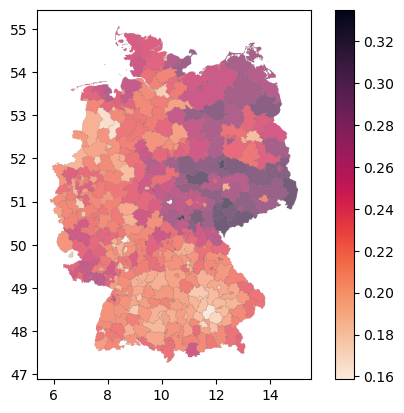

In [28]:
#illustrate results on map of Germany

#shoutout to https://github.com/jgehrcke/covid-19-germany-gae

import seaborn

fig, ax = plt.subplots()

print(geomerged[['ratio_65year', 'GEN']].to_string(index=False))

#graph
geomerged.plot(
    ax=ax,
    alpha=0.7,
    column="ratio_65year",
    linewidth=0.1,
    edgecolor="#555",
    categorical=False,
    legend=True,
        # cmap="autumn_r",
        # This is a key decision here. Lovely background info:
        # https://seaborn.pydata.org/tutorial/color_palettes.html
        # Use a sequential one.
    cmap=seaborn.color_palette("rocket_r", as_cmap=True),
    )


# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

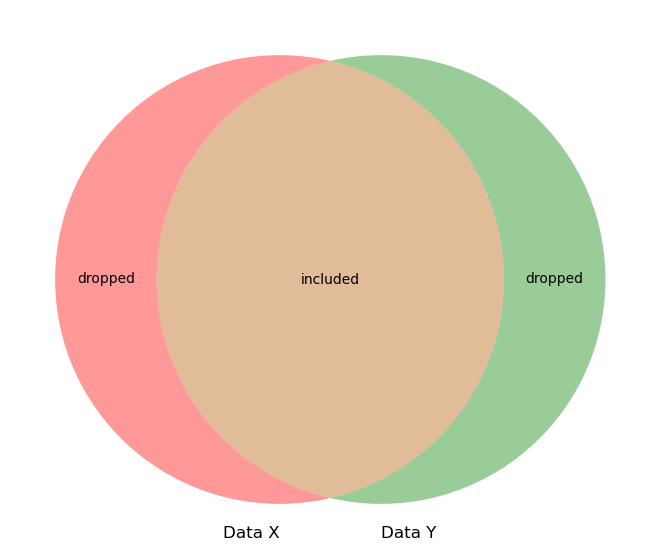

In [16]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.